# LSTM

#### I want to se how LSTM performs on a large dataset predicting just a day ahead
###### Using the Time Series: "con no1 mwh/h cet min15 a"

In [26]:
import wapi # wattsights egen pakke / den må installers via `pip install wapi-python`
import pandas as pd
import os
import numpy as np
from datetime import datetime 
from datetime import timedelta

# Create a session
# Dette forutsetter at dere har lagret volue credentials som miljøvariabler på PC'en deres og med navnet `WS_CLIENT_ID` og `WS_CLIENT_SECRET`
user = os.getenv("WS_CLIENT_ID")
password = os.getenv("WS_CLIENT_SECRET")
session = wapi.Session(client_id=user, client_secret=password)

start = '2021-06-16'
end = '2022-06-16'
periods=pd.date_range(start,end,freq='D')

curves = ['con no1 mwh/h cet min15 a',
'tt no1 con ec00 °c cet min15 f',
'pro no1 wnd ec00 mwh/h cet min15 f',
'pro no1 spv ec00 mwh/h cet min15 f'
]

df_watt = pd.DataFrame()
for curve in curves:
    print(f"Working with {curve}")
    curve = session.get_curve(name=curve)
    curve_type = curve.curve_type
    res = []
    counter = 1
    if curve_type == 'TIME_SERIES':
        ts = curve.get_data(data_from=start, data_to=end, function='SAVERAGE', frequency='MIN15')
        watt_temp = ts.to_pandas()
        df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')
        continue
    
    for j in range(len(periods)):
        if j == len(periods)-1:
            continue
        if curve_type == 'TAGGED_INSTANCES':
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='MIN15', tags=['Avg'])
        else: #curve_type == 'INSTANCES'
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='MIN15')
        # check if ts_list is empty and if yes, jump over that timestamp
        if not ts_list:
            continue
        pd_s = ts_list[0].to_pandas()
        if pd_s.empty:
            continue
        pd_s = pd_s.sort_index(ascending=True)
        pd_s = pd_s[:24]
        res.append(pd_s)
        print(f'Done {counter} out of {len(periods)}')
        counter += 1

    for k in range(len(res)):
        if k == 0:
            watt = pd.Series(res[k])
        else:
            watt = pd.concat([watt, res[k]])
    watt_temp = watt.rename(curve)
    df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')


Working with con no1 mwh/h cet min15 a
Working with tt no1 con ec00 °c cet min15 f
Done 1 out of 366
Done 2 out of 366
Done 3 out of 366
Done 4 out of 366
Done 5 out of 366
Done 6 out of 366
Done 7 out of 366
Done 8 out of 366
Done 9 out of 366
Done 10 out of 366
Done 11 out of 366
Done 12 out of 366
Done 13 out of 366
Done 14 out of 366
Done 15 out of 366
Done 16 out of 366
Done 17 out of 366
Done 18 out of 366
Done 19 out of 366
Done 20 out of 366
Done 21 out of 366
Done 22 out of 366
Done 23 out of 366
Done 24 out of 366
Done 25 out of 366
Done 26 out of 366
Done 27 out of 366
Done 28 out of 366
Done 29 out of 366
Done 30 out of 366
Done 31 out of 366
Done 32 out of 366
Done 33 out of 366
Done 34 out of 366
Done 35 out of 366
Done 36 out of 366
Done 37 out of 366
Done 38 out of 366
Done 39 out of 366
Done 40 out of 366
Done 41 out of 366
Done 42 out of 366
Done 43 out of 366
Done 44 out of 366
Done 45 out of 366
Done 46 out of 366
Done 47 out of 366
Done 48 out of 366
Done 49 out of

In [27]:
df_watt.columns = ["cons_actual", "temp_forecast", "wind_forecast", "solar_forecast"]
df_watt.dropna(inplace=True)
df_watt.tail()

,cons_actual,temp_forecast,wind_forecast,solar_forecast
2022-06-15 04:45:00+02:00,2128.0,11.0,51.477353,0.004659
2022-06-15 05:00:00+02:00,2195.0,11.4,51.477353,0.033182
2022-06-15 05:15:00+02:00,2195.0,11.4,51.477353,0.033182
2022-06-15 05:30:00+02:00,2195.0,11.4,51.477353,0.033182
2022-06-15 05:45:00+02:00,2195.0,11.4,51.477353,0.033182


## Preprocessing

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#### Adding Day- and Week- cos and sin

In [29]:
df_watt['Seconds'] = df_watt.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
week = day*7
df_watt['Day sin'] = np.sin(df_watt['Seconds'] * (2* np.pi / day))
df_watt['Day cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / day))
df_watt['Week sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / week))
df_watt['Week cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / week))

df_watt=df_watt.drop(['Seconds'], axis=1)
df_watt.head()


,cons_actual,temp_forecast,wind_forecast,solar_forecast,Day sin,Day cos,Week sin,Week cos
2021-06-16 00:00:00+02:00,2591.0,10.4,48.654523,0.0,-0.500000,0.866025,-0.826239,0.563320
2021-06-16 00:15:00+02:00,2591.0,10.4,48.654523,0.0,-0.442289,0.896873,-0.820936,0.571021
2021-06-16 00:30:00+02:00,2591.0,10.4,48.654523,0.0,-0.382683,0.923880,-0.815561,0.578671
2021-06-16 00:45:00+02:00,2591.0,10.4,48.654523,0.0,-0.321439,0.946930,-0.810115,0.586271
2021-06-16 01:00:00+02:00,2473.0,9.5,45.029284,0.0,-0.258819,0.965926,-0.804598,0.593820


In [30]:
cols = list(df_watt)[0:8]
#New dataframe with only training data - 4 columns
df_for_training = df_watt[cols].astype(float)
df_for_training.head()

,cons_actual,temp_forecast,wind_forecast,solar_forecast,Day sin,Day cos,Week sin,Week cos
2021-06-16 00:00:00+02:00,2591.0,10.4,48.654523,0.0,-0.500000,0.866025,-0.826239,0.563320
2021-06-16 00:15:00+02:00,2591.0,10.4,48.654523,0.0,-0.442289,0.896873,-0.820936,0.571021
2021-06-16 00:30:00+02:00,2591.0,10.4,48.654523,0.0,-0.382683,0.923880,-0.815561,0.578671
2021-06-16 00:45:00+02:00,2591.0,10.4,48.654523,0.0,-0.321439,0.946930,-0.810115,0.586271
2021-06-16 01:00:00+02:00,2473.0,9.5,45.029284,0.0,-0.258819,0.965926,-0.804598,0.593820


#### Normalizing the data

In [31]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

df_for_training_scaled

array([[-0.74205361,  0.83034725, -0.56282672, ...,  0.11990251,
        -1.16604072,  0.79490613],
       [-0.74205361,  0.83034725, -0.56282672, ...,  0.29901844,
        -1.15853945,  0.80579413],
       [-0.74205361,  0.83034725, -0.56282672, ...,  0.45583414,
        -1.15093667,  0.81661156],
       ...,
       [-1.13141026,  0.97091746, -0.51383787, ..., -1.08018834,
        -0.9881313 ,  1.00751328],
       [-1.13141026,  0.97091746, -0.51383787, ..., -1.37390801,
        -0.97864913,  1.01672927],
       [-1.13141026,  0.97091746, -0.51383787, ..., -1.68276419,
        -0.96908118,  1.02585623]])

#### Reshape the data

In [50]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of timesteps we want to look into the future based on the past timesteps.
n_past = 10  # Number of past timesteps we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (8742, 10, 8).
trainY shape == (8742, 1).


#### Define Autoencoder

In [51]:
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 32)            5248      
                                                                 
 lstm_13 (LSTM)              (None, 64)                24832     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 30,145
Trainable params: 30,145
Non-trainable params: 0
_________________________________________________________________


In [52]:
n_past = 4 * 24 * 10 
n_days_for_prediction= 24 * 4  #let us predict (<>*15min) hours

history = model.fit(trainX[:-n_days_for_prediction], trainY[:-n_days_for_prediction], epochs=10, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/10
433/433 [==============================] - 6s 9ms/step - loss: 0.0623 - val_loss: 0.0250
Epoch 2/10
433/433 [==============================] - 4s 9ms/step - loss: 0.0231 - val_loss: 0.0161
Epoch 3/10
433/433 [==============================] - 4s 9ms/step - loss: 0.0208 - val_loss: 0.0156
Epoch 4/10
433/433 [==============================] - 4s 8ms/step - loss: 0.0196 - val_loss: 0.0114
Epoch 5/10
433/433 [==============================] - 3s 8ms/step - loss: 0.0189 - val_loss: 0.0113
Epoch 6/10
433/433 [==============================] - 4s 8ms/step - loss: 0.0174 - val_loss: 0.0085
Epoch 7/10
433/433 [==============================] - 3s 8ms/step - loss: 0.0172 - val_loss: 0.0111
Epoch 8/10
433/433 [==============================] - 3s 8ms/step - loss: 0.0168 - val_loss: 0.0090
Epoch 9/10
433/433 [==============================] - 4s 9ms/step - loss: 0.0157 - val_loss: 0.0117
Epoch 10/10
433/433 [==============================] - 3s 8ms/step - loss: 0.0162 - val_loss: 0.0060

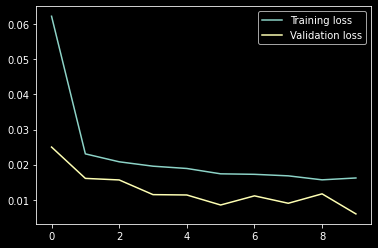

In [53]:
plt.style.use('dark_background')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [54]:


#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
#print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

3/3 [==============================] - 0s 4ms/step


In [55]:
prediction.shape

(96, 1)

In [56]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
y_pred_future.size

96

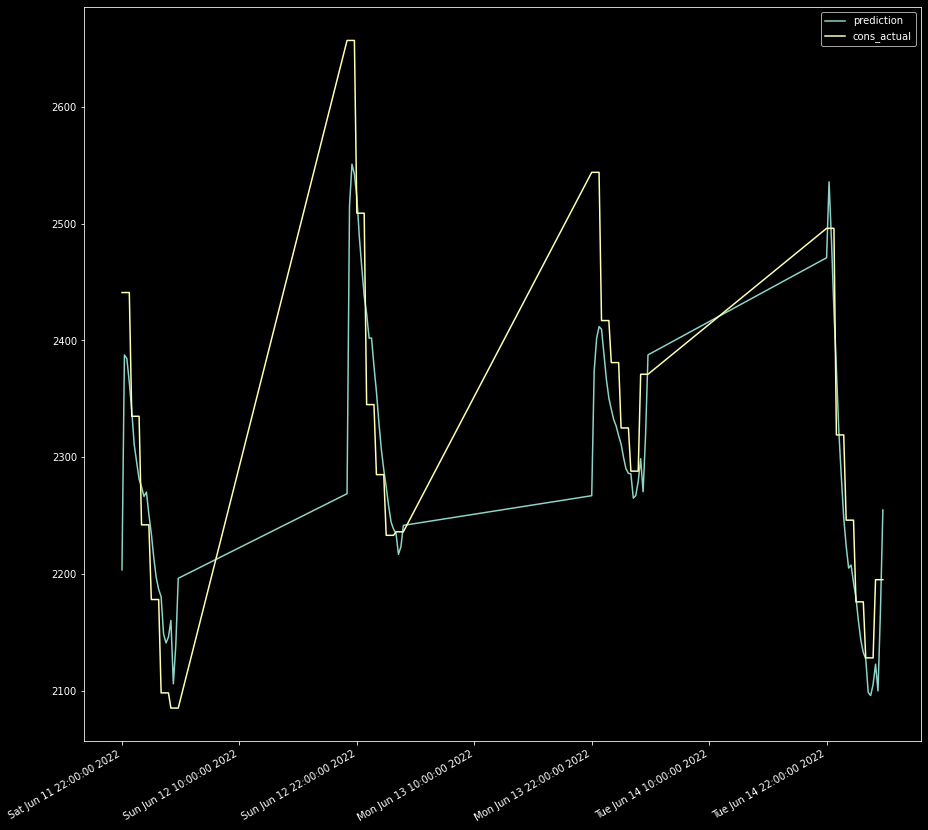

In [57]:
import matplotlib.dates as mdates


plt.figure(figsize=(15,15))
plt.plot(df_watt.index[-n_days_for_prediction:], y_pred_future, label='prediction')
plt.plot(df_watt['cons_actual'][-n_days_for_prediction:], label='cons_actual')
#Beautify x-axis
plt.xticks(rotation=90)
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter("%c")
plt.gca().xaxis.set_major_formatter(myFmt)

plt.legend()
plt.show()

#### This looks like a good fit, but lets add some quantifiers to how good it is

In [18]:
df_watt.shape

(35040, 9)

In [14]:
score = model.evaluate(trainX, trainY, verbose=0)
score

0.008413919247686863

### I want to try the model on completely new data

In [15]:
#Lets test the model on data from a year before
start2 = '2021-01-16'
end2 = '2021-06-16'
periods2=pd.date_range(start,end,freq='D')

curves2 = ['con no1 mwh/h cet min15 a',
'tt no1 con ec00 °c cet min15 f',
'pro no1 wnd ec00 mwh/h cet min15 f',
'pro no1 spv ec00 mwh/h cet min15 f'
]

df_watt2 = pd.DataFrame()
for curve in curves2:
    print(f"Working with {curve}")
    curve = session.get_curve(name=curve)
    curve_type = curve.curve_type
    res = []
    counter = 1
    if curve_type == 'TIME_SERIES':
        ts = curve.get_data(data_from=start, data_to=end, function='SAVERAGE', frequency='MIN15')
        watt_temp = ts.to_pandas()
        df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')
        continue
    
    for j in range(len(periods)):
        if j == len(periods)-1:
            continue
        if curve_type == 'TAGGED_INSTANCES':
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='MIN15', tags=['Avg'])
        else: #curve_type == 'INSTANCES'
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='MIN15')
        # check if ts_list is empty and if yes, jump over that timestamp
        if not ts_list:
            continue
        pd_s = ts_list[0].to_pandas()
        if pd_s.empty:
            continue
        pd_s = pd_s.sort_index(ascending=True)
        pd_s = pd_s[:24]
        res.append(pd_s)
        print(f'Done {counter} out of {len(periods)}')
        counter += 1

    for k in range(len(res)):
        if k == 0:
            watt = pd.Series(res[k])
        else:
            watt = pd.concat([watt, res[k]])
    watt_temp2 = watt.rename(curve)
    df_watt2 = pd.merge(df_watt2, watt_temp2, left_index=True, right_index=True, how='outer')

Working with con no1 mwh/h cet min15 a
Working with tt no1 con ec00 °c cet min15 f
Done 1 out of 366
Done 2 out of 366
Done 3 out of 366
Done 4 out of 366
Done 5 out of 366
Done 6 out of 366
Done 7 out of 366
Done 8 out of 366
Done 9 out of 366
Done 10 out of 366
Done 11 out of 366
Done 12 out of 366
Done 13 out of 366
Done 14 out of 366
Done 15 out of 366
Done 16 out of 366
Done 17 out of 366
Done 18 out of 366
Done 19 out of 366
Done 20 out of 366
Done 21 out of 366
Done 22 out of 366
Done 23 out of 366
Done 24 out of 366
Done 25 out of 366
Done 26 out of 366
Done 27 out of 366
Done 28 out of 366
Done 29 out of 366
Done 30 out of 366
Done 31 out of 366
Done 32 out of 366
Done 33 out of 366
Done 34 out of 366
Done 35 out of 366
Done 36 out of 366
Done 37 out of 366
Done 38 out of 366
Done 39 out of 366
Done 40 out of 366
Done 41 out of 366
Done 42 out of 366
Done 43 out of 366
Done 44 out of 366
Done 45 out of 366
Done 46 out of 366
Done 47 out of 366
Done 48 out of 366
Done 49 out of

KeyboardInterrupt: 

In [ ]:
df_watt2.columns = ["cons_actual", "temp_forecast", "wind_forecast", "solar_forecast"]
df_watt2.dropna(inplace=True)
df_watt2.tail()

,cons_actual,temp_forecast,wind_forecast,solar_forecast
2021-06-15 04:45:00+02:00,2367.0,8.8,159.601699,0.005099
2021-06-15 05:00:00+02:00,2454.0,9.5,156.741453,0.036253
2021-06-15 05:15:00+02:00,2454.0,9.5,156.741453,0.036253
2021-06-15 05:30:00+02:00,2454.0,9.5,156.741453,0.036253
2021-06-15 05:45:00+02:00,2454.0,9.5,156.741453,0.036253


In [ ]:
df_watt2['Seconds'] = df_watt.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
week = day*7
df_watt2['Day sin'] = np.sin(df_watt2['Seconds'] * (2* np.pi / day))
df_watt2['Day cos'] = np.cos(df_watt2['Seconds'] * (2 * np.pi / day))
df_watt2['Week sin'] = np.sin(df_watt2['Seconds'] * (2 * np.pi / week))
df_watt2['Week cos'] = np.cos(df_watt2['Seconds'] * (2 * np.pi / week))

df_watt2=df_watt2.drop(['Seconds'], axis=1)
df_watt2.head()

,cons_actual,temp_forecast,wind_forecast,solar_forecast,Day sin,Day cos,Week sin,Week cos
2021-01-16 00:00:00+01:00,6472.0,-11.7,35.756445,0.0,-2.588190e-01,0.965926,0.982566,-0.185912
2021-01-16 00:15:00+01:00,6472.0,-11.7,35.756445,0.0,-1.950903e-01,0.980785,0.980785,-0.195090
2021-01-16 00:30:00+01:00,6472.0,-11.7,35.756445,0.0,-1.305262e-01,0.991445,0.978918,-0.204252
2021-01-16 00:45:00+01:00,6472.0,-11.7,35.756445,0.0,-6.540313e-02,0.997859,0.976966,-0.213396
2021-01-16 01:00:00+01:00,6343.0,-11.8,35.756445,0.0,2.583671e-13,1.000000,0.974928,-0.222521


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
cols = list(df_watt)[0:8]
#New dataframe with only training data - 4 columns
df_for_training = df_watt[cols].astype(float)
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of timesteps we want to look into the future based on the past timesteps.
n_past = 10  # Number of past timesteps we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3598, 10, 8).
trainY shape == (3598, 1).


In [ ]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

3/3 [==============================] - 0s 7ms/step


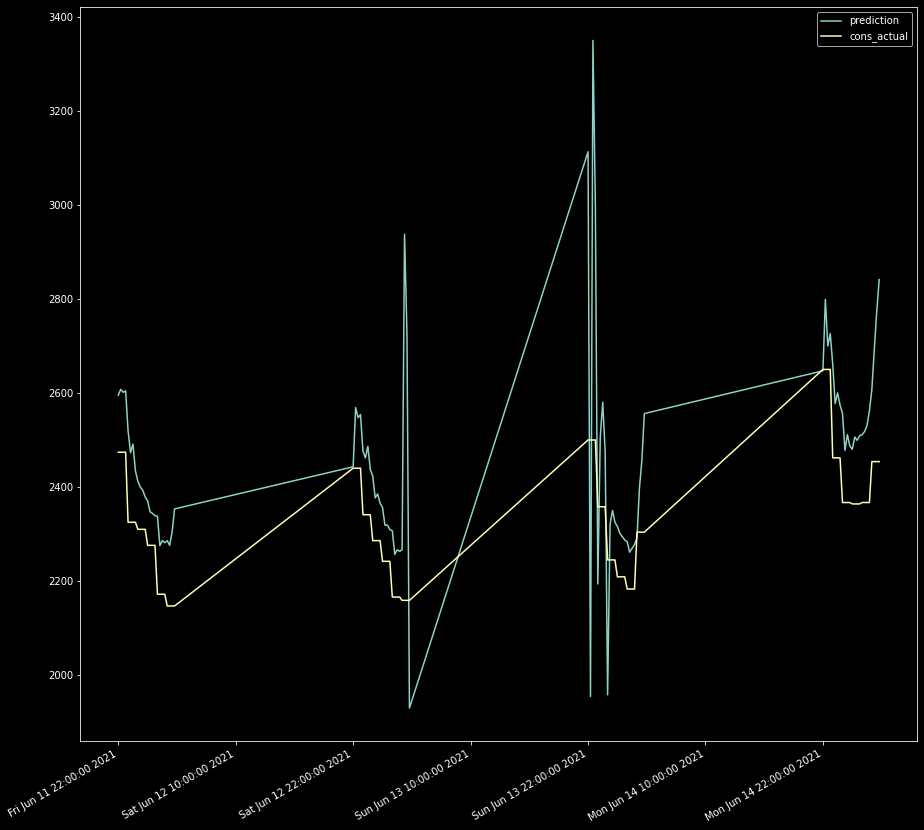

In [ ]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

import matplotlib.dates as mdates


plt.figure(figsize=(15,15))
plt.plot(df_watt.index[-n_days_for_prediction:], y_pred_future, label='prediction')
plt.plot(df_watt['cons_actual'][-n_days_for_prediction:], label='cons_actual')
#Beautify x-axis
plt.xticks(rotation=90)
plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter("%c")
plt.gca().xaxis.set_major_formatter(myFmt)

plt.legend()
plt.show()

# Nope